In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

In [12]:
# load some helper utils for running for long time
if not os.path.isfile('workspace_utils.py'):
    !curl -O https://raw.githubusercontent.com/udacity/workspaces-student-support/master/jupyter/workspace_utils.py
from workspace_utils import active_session

## Create your training and testing data:

In [13]:
from source.train import _create_dataset
create_new_trainval_set = 0
input_file = '/data/Data_Entry_2017.csv'
output_trainfile = os.path.join('processed_data', 'train_data.csv')
output_valfile = os.path.join('processed_data', 'val_data.csv') 
if create_new_trainval_set:
    _create_dataset(input_file = input_file,
                       output_trainfile = output_trainfile,
                    output_valfile = output_valfile)
train_data, val_data = pd.read_csv(output_trainfile), pd.read_csv(output_valfile)

## Create your training and testing data:

In [14]:
from source.train import create_splits
dev_flag = 1
if dev_flag:
    train_data = train_data.sample(1500)

#### First suggestion: perform some image augmentation on your data

In [15]:
from source.train import TrainGen, make_val_gen
train_gen = TrainGen(train_data)
val_gen = make_val_gen(val_data, imgpath_col = 'path', class_col = 'pneumonia_class')

Found 24 validated image filenames belonging to 2 classes.
Found 286 validated image filenames belonging to 2 classes.


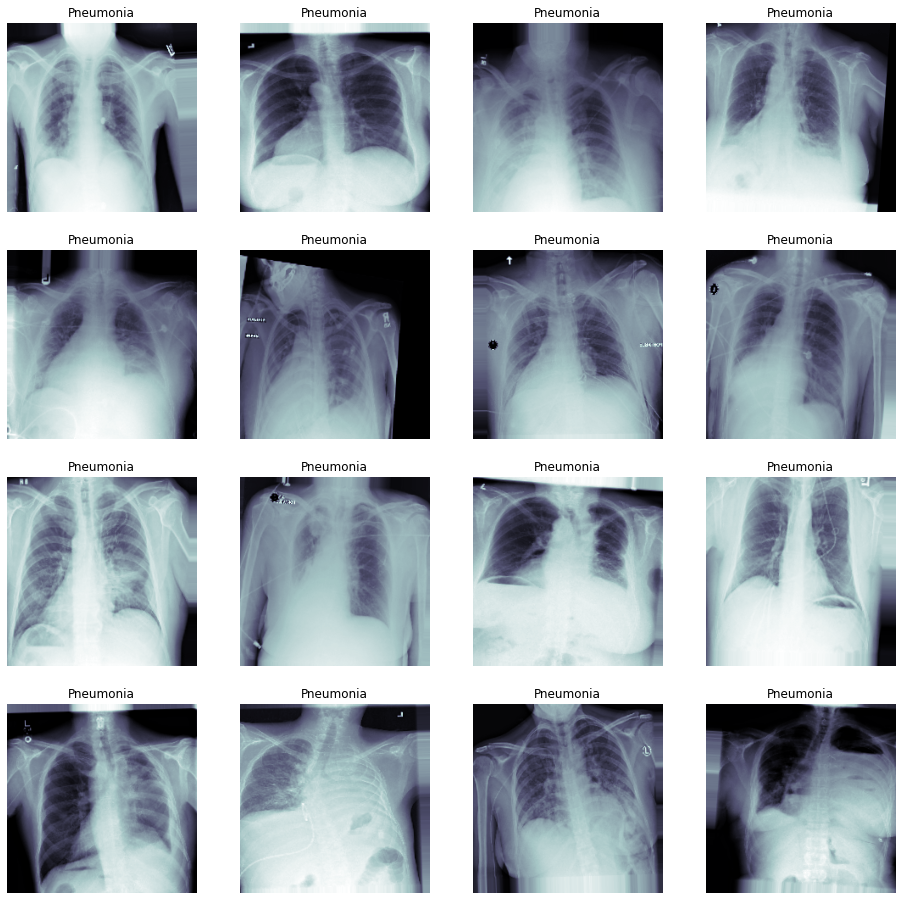

In [16]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen.train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [17]:
from source.model import load_pretrained_model
vgg_model = load_pretrained_model()

In [18]:
from source.model import build_my_model
my_model = build_my_model(vgg_model)

Use lr_finder from https://github.com/surmenok/keras_lr_finder/blob/master/keras_lr_finder/lr_finder.py
Epoch 1/1
2/2 [==============================] - 35s 17s/step - loss: 3.5360e-11


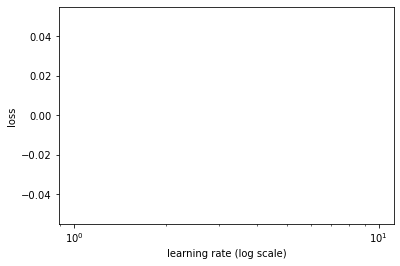

In [33]:
# Find suitable learning rates
from source.train import find_optimal_lr 
r_finder = find_optimal_lr(my_model, train_gen, epochs = 1)
r_finder.plot_loss(n_skip_beginning = 0, n_skip_end = 0)

In [50]:
from source.train import build_callbacks_list
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo
weight_path = "{}_my_model.best.hdf5".format('xray_class')
callbacks_list = build_callbacks_list(weight_path = weight_path,
                                      initial_learning_rate = 0.0001,
                                      maximal_learning_rate = 0.1)

In [51]:
from source.train import train

## train your model
history = train(model = my_model,
                callbacks_list = callbacks_list, 
                train_gen = train_gen, 
                validation_data = val_gen,
               epochs = 2)

Epoch 1/2


KeyboardInterrupt: 

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [24]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(val_gen, verbose = True)

9/9 [==============================] - 190s 21s/step


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


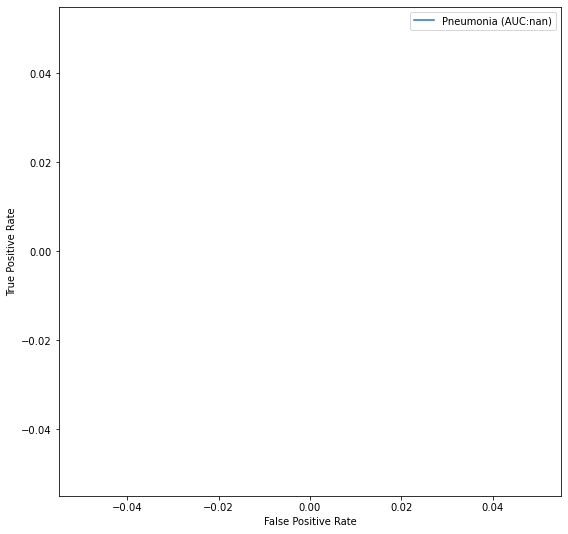

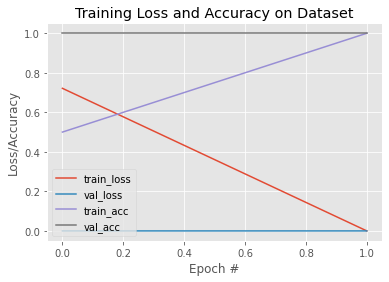

In [13]:
from source.predict import plot_auc, plot_history, calc_f1, plot_history

probability = pred_Y.flatten()
ground_truth = val_gen.labels
plot_auc(ground_truth, probability)
plot_history(history)    

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
YOUR_THRESHOLD = 0.5

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [ ]:
## Just save model architecture to a .json:
model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)